In [1]:
import graphlab
from __future__ import division
import numpy as np
import string
import matplotlib.pyplot as plt
graphlab.canvas.set_target('ipynb')

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
/opt/conda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/opt/conda/lib/python2.7/site-packages/requests/packages/urllib3/connection.py:266: SubjectAltNameWarning: Certificate for beta.graphlab.com has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/shazow/urllib3/issues/497 for details.)
  SubjectAltNameWarning
[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1500887341.log


This non-commercial license of GraphLab Create for academic use is assigned to mukesh.mithrakumar@jacks.sdstate.edu and will expire on June 17, 2018.


/opt/conda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
products = graphlab.SFrame('amazon_baby_subset.gl/')

In [3]:
def remove_punctuation(text):
    return text.translate(None, string.punctuation) 

# Remove punctuation.
review_clean = products['review'].apply(remove_punctuation)

# Count words
products['word_count'] = graphlab.text_analytics.count_words(review_clean)

# Drop neutral sentiment reviews.
products = products[products['rating'] != 3]

# Positive sentiment to +1 and negative sentiment to -1
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [5]:
train_data, test_data = products.random_split(.8, seed=1)

In [6]:
model = graphlab.logistic_classifier.create(train_data, target='sentiment',
                                            features=['word_count'],
                                            validation_set=None)

WARNING: The number of feature dimensions in this problem is very large in comparison with the number of examples. Unless an appropriate regularization value is set, this model may not provide accurate predictions for a validation/test set.

Logistic regression:

--------------------------------------------------------

Number of examples          : 42474

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 61417

Number of coefficients    : 61418

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 1         | 3        | 0.000024  | 1.619183     | 0.818925          |

| 2         | 5        | 1.000000  | 2.220542     | 0.925743          |

| 3         | 6        | 1.000000  | 2.609471     | 0.935914          |

| 4         | 7        | 1.000000  | 2.999945     | 0.959881          |

| 5         | 8        | 1.000000  | 3.415791     | 0.967086          |

| 6         | 9        | 1.000000  | 3.820404     | 0.972218          |

| 10        | 13       | 1.000000  | 5.363637     | 0.984414          |

+-----------+----------+-----------+--------------+-------------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

In [7]:
accuracy= model.evaluate(test_data, metric='accuracy')['accuracy']
print "Test Accuracy: %s" % accuracy

Test Accuracy: 0.870541611625


## Baseline: Majority class prediction

Recall from an earlier assignment that we used the **majority class classifier** as a baseline (i.e reference) model for a point of comparison with a more sophisticated classifier. The majority classifier model predicts the majority class for all data points. 

Typically, a good model should beat the majority class classifier. Since the majority class in this dataset is the positive class (i.e., there are more positive than negative reviews), the accuracy of the majority class classifier can be computed as follows:

In [8]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print "Baseline accuracy (majority class classifier): %s" % baseline

Baseline accuracy (majority class classifier): 0.506793734667


In [9]:
confusion_matrix = model.evaluate(test_data, metric='confusion_matrix')['confusion_matrix']
confusion_matrix

target_label,predicted_label,count
1,1,4823
-1,-1,4403
1,-1,548
-1,1,824


In [11]:
cost = 100*824 + 1*548
print cost

82948


In [12]:
precision = model.evaluate(test_data, metric='precision')['precision']
print "Precision on test data: %s" % precision

Precision on test data: 0.854081813352


In [13]:
false_positives = 4823/(4283+824)
print false_positives

0.944390052869


In [16]:
(4283+824)/confusion_matrix['count'].sum()

0.48188337422155125

In [17]:
recall = model.evaluate(test_data, metric='recall')['recall']
print "Recall on test data: %s" % recall

Recall on test data: 0.897970582759


In [22]:
def apply_threshold(probabilities, threshold):
    # +1 if >= threshold and -1 otherwise
    ans = graphlab.SArray([+1 if x >= threshold else -1 for x in probabilities])
    return ans

In [23]:
probabilities = model.predict(test_data, output_type='probability')
predictions_with_default_threshold = apply_threshold(probabilities, 0.5)
predictions_with_high_threshold = apply_threshold(probabilities, 0.9)

In [24]:
print "Number of positive predicted reviews (threshold = 0.5): %s" % (predictions_with_default_threshold == 1).sum()

Number of positive predicted reviews (threshold = 0.5): 5647


In [25]:
print "Number of positive predicted reviews (threshold = 0.9): %s" % (predictions_with_high_threshold == 1).sum()

Number of positive predicted reviews (threshold = 0.9): 4721


In [26]:
# Threshold = 0.5
precision_with_default_threshold = graphlab.evaluation.precision(test_data['sentiment'],
                                        predictions_with_default_threshold)

recall_with_default_threshold = graphlab.evaluation.recall(test_data['sentiment'],
                                        predictions_with_default_threshold)

# Threshold = 0.9
precision_with_high_threshold = graphlab.evaluation.precision(test_data['sentiment'],
                                        predictions_with_high_threshold)
recall_with_high_threshold = graphlab.evaluation.recall(test_data['sentiment'],
                                        predictions_with_high_threshold)

In [27]:
print "Precision (threshold = 0.5): %s" % precision_with_default_threshold
print "Recall (threshold = 0.5)   : %s" % recall_with_default_threshold

Precision (threshold = 0.5): 0.854081813352
Recall (threshold = 0.5)   : 0.897970582759


In [28]:
print "Precision (threshold = 0.9): %s" % precision_with_high_threshold
print "Recall (threshold = 0.9)   : %s" % recall_with_high_threshold

Precision (threshold = 0.9): 0.916543105274
Recall (threshold = 0.9)   : 0.805622789052


In [29]:
threshold_values = np.linspace(0.5, 1, num=100)
print threshold_values

[ 0.5         0.50505051  0.51010101  0.51515152  0.52020202  0.52525253
  0.53030303  0.53535354  0.54040404  0.54545455  0.55050505  0.55555556
  0.56060606  0.56565657  0.57070707  0.57575758  0.58080808  0.58585859
  0.59090909  0.5959596   0.6010101   0.60606061  0.61111111  0.61616162
  0.62121212  0.62626263  0.63131313  0.63636364  0.64141414  0.64646465
  0.65151515  0.65656566  0.66161616  0.66666667  0.67171717  0.67676768
  0.68181818  0.68686869  0.69191919  0.6969697   0.7020202   0.70707071
  0.71212121  0.71717172  0.72222222  0.72727273  0.73232323  0.73737374
  0.74242424  0.74747475  0.75252525  0.75757576  0.76262626  0.76767677
  0.77272727  0.77777778  0.78282828  0.78787879  0.79292929  0.7979798
  0.8030303   0.80808081  0.81313131  0.81818182  0.82323232  0.82828283
  0.83333333  0.83838384  0.84343434  0.84848485  0.85353535  0.85858586
  0.86363636  0.86868687  0.87373737  0.87878788  0.88383838  0.88888889
  0.89393939  0.8989899   0.9040404   0.90909091  0.

In [31]:
precision_all = []
recall_all = []

probabilities = model.predict(test_data, output_type='probability')
for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    
    precision = graphlab.evaluation.precision(test_data['sentiment'], predictions)
    recall = graphlab.evaluation.recall(test_data['sentiment'], predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

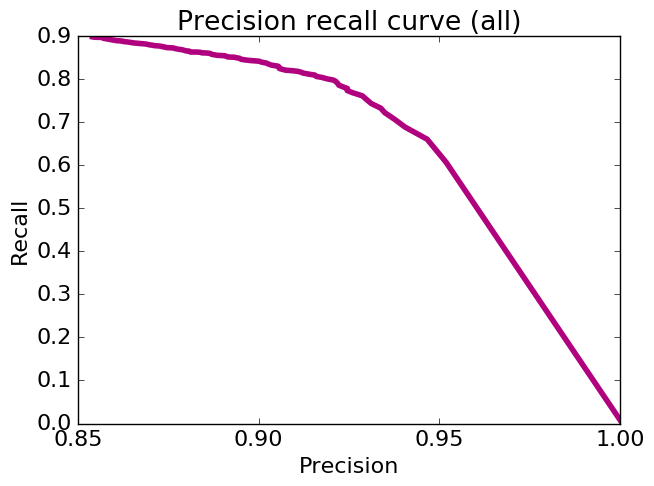

In [32]:
%matplotlib inline

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})
    
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

In [ ]:
#Among all the threshold values tried, what is the smallest threshold value that achieves a precision of 96.5% or better? 


In [33]:
threshold_values[np.array(precision_all) >= 0.965].min()

1.0

In [34]:
threshold = 0.98
predictions = apply_threshold(probabilities, threshold)
confusion_matrix = graphlab.evaluation.confusion_matrix(test_data['sentiment'], predictions)
confusion_matrix

target_label,predicted_label,count
-1,1,252
1,-1,1577
-1,-1,4975
1,1,3794


In [35]:
baby_reviews =  test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]

In [36]:
probabilities = model.predict(baby_reviews, output_type='probability')

In [37]:
threshold_values = np.linspace(0.5, 1, num=100)

In [41]:
precision_all = []
recall_all = []

for threshold in threshold_values:
    
    # Make predictions. Use the `apply_threshold` function 
    predictions = apply_threshold(probabilities, threshold)

    # Calculate the precision.
    precision = graphlab.evaluation.precision(baby_reviews['sentiment'], predictions)
    recall = graphlab.evaluation.recall(baby_reviews['sentiment'], predictions)
    
    # Append the precision and recall scores.
    precision_all.append(precision)
    recall_all.append(recall)

In [42]:
threshold_values[np.array(precision_all) >= 0.965].min()

1.0

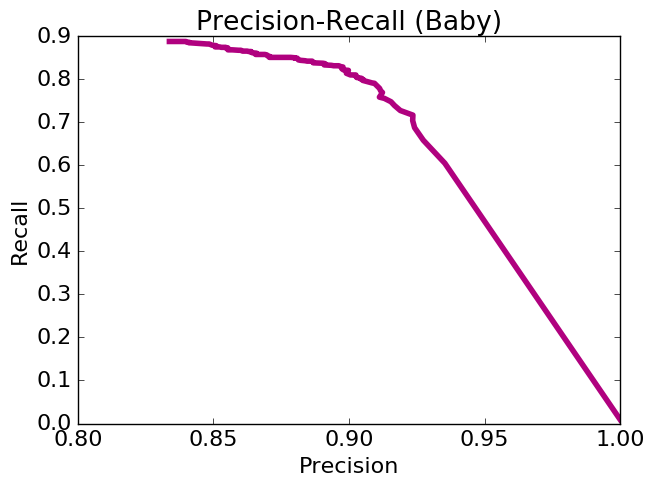

In [43]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")